In [ ]:
# References
# https://arxiv.org/pdf/1609.04802
#https://github.com/deepak112/Keras-SRGAN

In [1]:
import tensorflow as tf
print(tf.__version__)

2.17.0


In [2]:
import keras
print(keras.__version__)

3.4.1


In [1]:

from keras import applications
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.src.optimizers import Adam
from keras.src.models import Model
from keras.src.layers import Input, Conv2D, MaxPooling2D, Activation, Dense, Flatten, Dropout
from keras.src.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from keras.src.utils import plot_model


# Modules
from keras.src.layers import Activation, BatchNormalization, UpSampling2D, Conv2D, Conv2DTranspose
from keras.src.layers import LeakyReLU, PReLU
from keras.src.layers import add


import matplotlib.pyplot as plt
from PIL import Image

import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import imageio

import keras.src.legacy.backend as K

import os
from pathlib import Path
from datetime import datetime

from tqdm import tqdm

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())



[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 105807198814235847
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2573945310701435066
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Image size

# Use 128 X 128 sz for high res images and use 32 X 32 for low res images
downscale_factor = 4
img_width_hr, img_height_hr, img_depth = 128, 128, 3
img_width_lr, img_height_lr = img_width_hr//downscale_factor, img_height_hr//downscale_factor
print (img_width_hr, img_height_hr, img_depth)
print (img_width_lr, img_height_lr)

hr_image_shape = (img_width_hr, img_height_hr, img_depth)
lr_image_shape = (img_width_lr, img_height_lr, img_depth)

#select a subset to train
target_num_images = 1000

# Training parameters
epochs = 150
batch_size = 32
freq = 25
num_classes = 2
train_test_ratio = 0.7


class_weights = {0: 1.,
                1: 2.}

if num_classes < 2:
    act_type = 'sigmoid'
    class_mode = 'binary'
    loss_fun = 'binary_crossentropy'
else:
    act_type = 'softmax'
    class_mode = 'categorical'
    loss_fun = 'categorical_crossentropy'

128 128 3
32 32


In [4]:
# Read Images

image_path = "gdrive/MyDrive/CatsAndDogs/train"
input_dir = image_path
model_save_dir = "gdrive/MyDrive/Midterm/model/"
output_dir = "gdrive/MyDrive/Midterm/output/"

In [5]:
image_filenames = Path(image_path).glob ("*.jpg")
image_filenames = list(image_filenames)
num_images = len(image_filenames)
print(num_images)

sample_images=random.sample(image_filenames, target_num_images)
print(len(sample_images))

12823
100


In [6]:
images_hr =[]
images_lr =[]
for file in sample_images:
  img = Image.open (file)
  img_hr = img.resize((img_width_hr, img_height_hr), resample=Image.BICUBIC)
  images_hr.append(img_hr)
  img_lr = img.resize((img_width_lr, img_height_lr), resample=Image.BICUBIC)
  images_lr.append(img_lr)

images_hr = np.array(images_hr)
images_lr = np.array(images_lr)
print(images_hr.shape)
print(images_lr.shape)


num_train_samples = int(target_num_images * train_test_ratio)
num_valid_samples = target_num_images - num_train_samples
print(num_train_samples)
print(num_valid_samples)

x_train_hr, x_test_hr = train_test_split( images_hr, test_size=num_valid_samples, random_state=1)
x_train_lr, x_test_lr = train_test_split( images_lr, test_size=num_valid_samples, random_state=1)

(100, 128, 128, 3)
(100, 32, 32, 3)
70
30


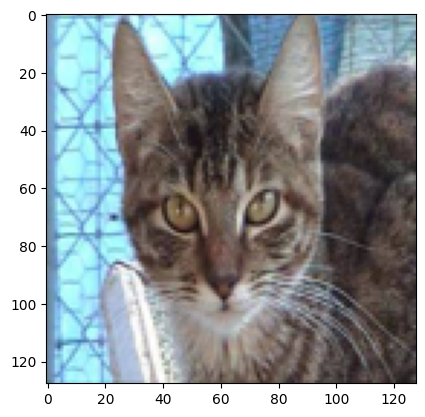

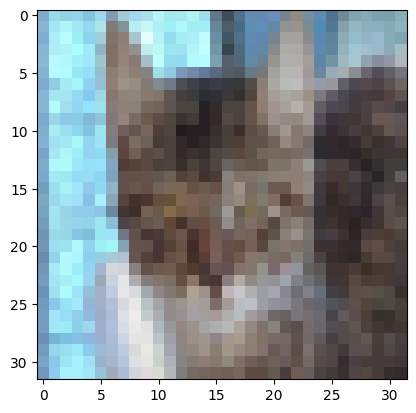

In [17]:
plt.imshow(x_train_hr[0])
plt.show()
plt.imshow(x_train_lr[0])
plt.show()

In [6]:
# While training save generated image(in form LR, SR, HR)
# Save only one image as sample
def plot_generated_images(output_dir, epoch, generator, x_test_hr, x_test_lr , dim=(1, 3), figsize=(15, 5)):

    examples = x_test_hr.shape[0]
    print(examples)
    value = randint(0, examples)
    image_batch_hr = denormalize(x_test_hr)
    image_batch_lr = x_test_lr
    gen_img = generator.predict(image_batch_lr)
    generated_image = denormalize(gen_img)
    image_batch_lr = denormalize(image_batch_lr)

    plt.figure(figsize=figsize)

    plt.subplot(dim[0], dim[1], 1)
    plt.imshow(image_batch_lr[value], interpolation='nearest')
    plt.axis('off')

    plt.subplot(dim[0], dim[1], 2)
    plt.imshow(generated_image[value], interpolation='nearest')
    plt.axis('off')

    plt.subplot(dim[0], dim[1], 3)
    plt.imshow(image_batch_hr[value], interpolation='nearest')
    plt.axis('off')

    plt.tight_layout()
    plt.savefig(output_dir + 'generated_image_%d.png' % epoch)

    #plt.show()

In [7]:
# Folder setup
init_time = datetime.now()
fold_num = 1
current_time = init_time.strftime('%Y%m%d_%H%M%S')
name_dir = 'gdrive/MyDrive/MidTerm/Classifier/trained_models_' + current_time + '_fold_num' + str(fold_num)
os.mkdir(name_dir)

# Callbacks1: ModelCheckpointer
model_file_format = name_dir + '/model_' + str(fold_num) + '_model.{epoch:04d}.keras'
check = ModelCheckpoint(model_file_format, save_freq = freq, verbose = 1)

# Callbacks2: TensorBoard
tensor_check = './logs/' + current_time + '_train_testsplit' + str(fold_num)
tensor_board = TensorBoard(tensor_check)

# Callbacks3: EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')
# Plot model
figure_name = name_dir + '/model_output.png'
#plot_model(model, figure_name, show_shapes = TRUE)

In [15]:
class VGG_LOSS(object):

    def __init__(self, image_shape):

        self.image_shape = image_shape

    # computes VGG loss or content loss
    def vgg_loss(self, y_true, y_pred):

        vgg19 = applications.vgg19.VGG19(include_top=False, weights='imagenet', input_shape=self.image_shape)
        vgg19.trainable = False
        # Make trainable as False
        for l in vgg19.layers:
            l.trainable = False
        model = Model(inputs=vgg19.input, outputs=vgg19.get_layer('block5_conv4').output)
        model.trainable = False

        return K.mean(K.square(model(y_true) - model(y_pred)))

def get_optimizer():

    adam = Adam(learning_rate=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    return adam

In [9]:
# Residual block
def res_block_gen(model, kernal_size, filters, strides):

    gen = model

    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
    # Using Parametric ReLU
    model = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(model)
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)

    model = add([gen, model])

    return model


def up_sampling_block(model, kernal_size, filters, strides):

    # In place of Conv2D and UpSampling2D we can also use Conv2DTranspose (Both are used for Deconvolution)
    # Even we can have our own function for deconvolution (i.e one made in Utils.py)
    #model = Conv2DTranspose(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(model)
    model = UpSampling2D(size = 2)(model)
    model = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(model)

    #model = LeakyReLU(alpha = 0.2)(model)

    return model


def discriminator_block(model, filters, kernel_size, strides):

    model = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
    model = LeakyReLU(alpha = 0.2)(model)

    return model

In [10]:

# Network Architecture is same as given in Paper https://arxiv.org/pdf/1609.04802.pdf
class Generator(object):

    def __init__(self, noise_shape):

        self.noise_shape = noise_shape

    def generator(self):

	    gen_input = Input(shape = self.noise_shape)

	    model = Conv2D(filters = 64, kernel_size = 9, strides = 1, padding = "same")(gen_input)
	    model = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(model)

	    gen_model = model

        # Using 16 Residual Blocks
	    for index in range(16):
	        model = res_block_gen(model, 3, 64, 1)

	    model = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = "same")(model)
	    model = BatchNormalization(momentum = 0.5)(model)
	    model = add([gen_model, model])

	    # Using 2 UpSampling Blocks
	    for index in range(2):
	        model = up_sampling_block(model, 3, 256, 1)

	    model = Conv2D(filters = 3, kernel_size = 9, strides = 1, padding = "same")(model)
	    model = Activation('tanh')(model)

	    generator_model = Model(inputs = gen_input, outputs = model)

	    return generator_model

# Network Architecture is same as given in Paper https://arxiv.org/pdf/1609.04802.pdf
class Discriminator(object):

    def __init__(self, image_shape):

        self.image_shape = image_shape

    def discriminator(self):

        dis_input = Input(shape = self.image_shape)

        model = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = "same")(dis_input)
        model = LeakyReLU(alpha = 0.2)(model)

        model = discriminator_block(model, 64, 3, 2)
        model = discriminator_block(model, 128, 3, 1)
        model = discriminator_block(model, 128, 3, 2)
        model = discriminator_block(model, 256, 3, 1)
        model = discriminator_block(model, 256, 3, 2)
        model = discriminator_block(model, 512, 3, 1)
        model = discriminator_block(model, 512, 3, 2)

        model = Flatten()(model)
        model = Dense(1024)(model)
        model = LeakyReLU(alpha = 0.2)(model)

        model = Dense(1)(model)
        model = Activation('sigmoid')(model)

        discriminator_model = Model(inputs = dis_input, outputs = model)

        return discriminator_model

In [11]:
# Combined network
def get_gan_network(discriminator, shape, generator, optimizer, vgg_loss):
    discriminator.trainable = False
    gan_input = Input(shape=shape)
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=[x,gan_output])
    gan.compile(loss=[vgg_loss, "binary_crossentropy"],
                loss_weights=[1., 1e-3],
                optimizer=optimizer)

    return gan

In [16]:
    loss = VGG_LOSS(hr_image_shape)

    batch_count = int(num_train_samples / batch_size)
    # shape = (image_shape[0]//downscale_factor, image_shape[1]//downscale_factor, image_shape[2])

    generator = Generator(lr_image_shape).generator()
    discriminator = Discriminator(hr_image_shape).discriminator()

    optimizer = get_optimizer()
    generator.compile(loss=loss.vgg_loss, optimizer=optimizer)
    discriminator.compile(loss="binary_crossentropy", optimizer=optimizer)

    gan = get_gan_network(discriminator, lr_image_shape, generator, optimizer, loss.vgg_loss)


    for e in range(1, 2):
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        start =0
        for _ in tqdm(range(batch_count)):

           # rand_nums = np.random.randint(0, num_train_samples, size=batch_size)
            rand_nums = np.random.randint(0, x_train_hr.shape[0], size=batch_size)

            image_batch_hr = x_train_hr[rand_nums]
            image_batch_lr = x_train_lr[rand_nums]

            generated_images_sr = generator.predict(image_batch_lr)

            real_data_Y = np.ones(batch_size) - np.random.random_sample(batch_size)*(1-train_test_ratio)
            fake_data_Y = np.random.random_sample(batch_size)*(1-train_test_ratio)

            discriminator.trainable = True

            d_loss_real = discriminator.train_on_batch(image_batch_hr, real_data_Y)
            d_loss_fake = discriminator.train_on_batch(generated_images_sr, fake_data_Y)
            discriminator_loss = 0.5 * np.add(d_loss_fake, d_loss_real)

            rand_nums = np.random.randint(0, x_train_hr.shape[0], size=batch_size)
            image_batch_hr = x_train_hr[rand_nums]
            image_batch_lr = x_train_lr[rand_nums]

            gan_Y = np.ones(batch_size) - np.random.random_sample(batch_size)*(1-train_test_ratio)
            discriminator.trainable = False
            gan_loss = gan.train_on_batch(image_batch_lr, [image_batch_hr,gan_Y])

        print("discriminator_loss : %f" % discriminator_loss)
        print("gan_loss :", gan_loss)
        gan_loss = str(gan_loss)

        loss_file = open(model_save_dir + 'losses.txt' , 'a')
        loss_file.write('epoch%d : ; discriminator_loss = %f\n' %(e,  discriminator_loss) )
        loss_file.close()

       # if e == 1 or e % 5 == 0:
       #     plot_generated_images(output_dir, e, generator, x_test_hr, x_test_lr)
        if e % 5 == 0:
            generator.save(model_save_dir + 'gen_model%d.h5' % e)
            discriminator.save(model_save_dir + 'dis_model%d.h5' % e)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


--------------- Epoch 1 ---------------


  0%|          | 0/2 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


  0%|          | 0/2 [00:21<?, ?it/s]


ValueError: Unknown variable: <KerasVariable shape=(9, 9, 3, 64), dtype=float32, path=conv2d_90/kernel>. This optimizer can only be called for the variables it was originally built with. When working with a new set of variables, you should recreate a new optimizer instance.